## 第一次速度模拟尝试

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 常量和参数
mass = 1.44e-25  # 原子的质量 (kg)
hbar = 1.0545718e-34  # 普朗克常数 (J·s)
k = 2 * np.pi / 780e-9  # 波矢 (m^-1)
gamma = 2 * np.pi * 6.07e6  # 自发辐射率 (Hz)
eta = 1e7  # 驱动强度 (Hz)
kappa = 2 * np.pi * 1.4e6  # 腔场衰减率 (Hz)
g = 2 * np.pi * 16e6  # 耦合强度 (Hz)
delta_a = 2 * np.pi * 35e6  # 原子失谐 (Hz)
delta_c = 0  # 腔失谐 (Hz)

# 初始条件
initial_position = np.array([0, 0, 0])  # 初始位置 (m)
initial_velocity = np.array([0, 0, 0])  # 初始速度 (m/s)
initial_conditions = np.concatenate([initial_position, initial_velocity])

# 定义计算力的函数
def calculate_forces(t, y):
    position = y[:3]
    velocity = y[3:]
    
    g_r = g * np.exp(-np.sum(position[:2]**2) / (2 * (780e-9)**2)) * np.cos(k * position[2])
    grad_g_r = np.array([0, 0, -k * g * np.exp(-np.sum(position[:2]**2) / (2 * (780e-9)**2)) * np.sin(k * position[2])])
    dipole_force = -hbar * eta**2 * g_r * grad_g_r / (delta_a * (kappa**2 + delta_c**2))
    
    # 速度相关力和动量扩散力可以加入到此处
    
    acceleration = dipole_force / mass
    return np.concatenate([velocity, acceleration])

# 数值积分运动方程
def simulate_trajectory(t_span, y0):
    sol = solve_ivp(calculate_forces, t_span, y0, method='RK45', rtol=1e-8, atol=1e-10)
    return sol

# 蒙特卡洛模拟参数
num_simulations = 100  # 模拟次数
time_span = (0, 1e-4)  # 时间范围 (s)
storage_times = []  # 存储时间列表

# 运行蒙特卡洛模拟
for _ in range(num_simulations):
    # 添加随机初始速度
    random_velocity = np.random.normal(0, 0.01, size=3)  # 初始速度随机扰动
    initial_conditions_with_random_velocity = np.concatenate([initial_position, random_velocity])
    
    # 模拟单个原子的轨迹
    solution = simulate_trajectory(time_span, initial_conditions_with_random_velocity)
    
    # 提取位置数据
    positions = solution.y[:3].T
    
    # 检查原子是否被捕获
    final_position = positions[-1]
    if np.all(np.abs(final_position) < 780e-9):
        storage_times.append(time_span[1])
    else:
        storage_times.append(solution.t[np.all(np.abs(positions) < 780e-9, axis=1)][-1])

# 绘制存储时间直方图
plt.hist(storage_times, bins=30, alpha=0.7, color='b', edgecolor='black')
plt.xlabel('Storage Time (s)')
plt.ylabel('Frequency')
plt.title('Distribution of Atom Storage Times')
plt.show()


## 加入时间演化过程

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants (these should be defined according to your system)
gamma = 1.0  # Atomic decay rate
kappa = 1.4  # Cavity decay rate
g = 16.0  # Coupling constant
delta_a = 35.0  # Atomic detuning
eta = 1.0  # Stochastic force term
beta = 0.1  # Friction coefficient
hbar = 1.0545718e-34  # Reduced Planck constant

# Langevin equation for atomic motion
def langevin(t, p, beta):
    dpdt = -beta * p + eta * np.random.normal()
    return dpdt

# Initial conditions
p0 = 0.0

# Time span
t_span = (0, 100)
t_eval = np.linspace(0, 100, 10)

# Solve the Langevin equation
sol = solve_ivp(langevin, t_span, [p0], args=(beta,), t_eval=t_eval)

# Plot results
plt.plot(sol.t, sol.y[0])
plt.xlabel('Time')
plt.ylabel('Momentum')
plt.title('Cavity Cooling Simulation')
plt.show()



In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
gamma = 1.0  # Atomic decay rate
delta_a = 35.0  # Atomic detuning
g = 16.0  # Coupling constant
eta = 1.0  # Stochastic force term
hbar = 1.0545718e-34  # Reduced Planck constant

# Langevin equation for atomic motion
def langevin(t, y, beta, eta):
    v, p = y
    dvdt = -beta * v + eta * np.random.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Function to simulate the system
def simulate_cooling(beta, eta, t_span, y0):
    sol = solve_ivp(langevin, t_span, y0, args=(beta, eta), t_eval=np.linspace(t_span[0], t_span[1], 100))
    return sol.t, sol.y[0], sol.y[1]

# Perform simulations for different κ values
kappas = np.linspace(0.1, 2.0, 5)
t_span = (0, 10)
y0 = [0.1, 0.01]  # Initial conditions: [initial velocity, initial momentum]

results = []
for kappa in tqdm(kappas, desc="Simulating", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    t, v, p = simulate_cooling(beta, eta, t_span, y0)
    results.append((kappa, v))

# Plot the results
plt.figure(figsize=(10, 6))
for kappa, v in results:
    plt.plot(t, v, label=f'κ = {kappa:.1f}')

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Atom Velocity vs. Time for Different Cavity Decay Rates')
plt.legend()
plt.show()


In [ ]:
pip install tqdm

## 不同 $\kappa$ 进行模拟

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
gamma = 1.0  # Atomic decay rate
delta_a = 35.0  # Atomic detuning
g = 16.0  # Coupling constant
eta = 1.0  # Stochastic force term
hbar = 1.0545718e-34  # Reduced Planck constant

# Langevin equation for atomic motion
def langevin(t, y, beta, eta):
    v, p = y
    dvdt = -beta * v + eta * np.random.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Function to simulate the system
def simulate_cooling(beta, eta, t_span, y0):
    sol = solve_ivp(langevin, t_span, y0, args=(beta, eta), t_eval=np.linspace(t_span[0], t_span[1], 100))
    return sol.t, sol.y[0], sol.y[1]

# Define the cooling time
cooling_time = 20  # Adjust this value to set the cooling time

# Define the initial conditions
initial_velocity = 1.0  # Initial velocity
initial_momentum = 0.01  # Initial momentum
y0 = [initial_velocity, initial_momentum]

# Perform simulations for different κ values
kappas = np.linspace(0.1, 2.0, 20)
t_span = (0, cooling_time)

results = []
final_velocities = []

# Proportionality constant
c = 1.0

for kappa in tqdm(kappas, desc="Simulating", unit="kappa"):
    beta = c * kappa  # Proportional relationship for simplicity
    t, v, p = simulate_cooling(beta, eta, t_span, y0)
    results.append((kappa, v))
    final_velocities.append(v[-1])  # Collect the final velocity

# Plot the results
plt.figure(figsize=(10, 6))
for kappa, v in results:
    plt.plot(t, v, label=f'κ = {kappa:.1f}')

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Atom Velocity vs. Time for Different Cavity Decay Rates')
plt.legend()
plt.show()

# Plot final velocities after the cooling time
plt.figure(figsize=(10, 6))
plt.plot(kappas, final_velocities, 'o-')
plt.xlabel('Cavity Decay Rate κ')
plt.ylabel('Final Velocity')
plt.title(f'Final Velocity after {cooling_time} seconds for Different Cavity Decay Rates')
plt.grid(True)
plt.show()


## 加入feedback

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
gamma = 3.0  # Atomic decay rate
delta_a = 20.0  # Atomic detuning
g = 16.0  # Coupling constant
eta = 1.0  # Stochastic force term
hbar = 1.0545718e-34  # Reduced Planck constant

# Feedback parameters
feedback_gain = 0.1  # Gain factor for the feedback mechanism
integration_time = 0.01  # Integration time for feedback in seconds

# Velocity threshold for determining storage time
velocity_threshold = 0.05

# Langevin equation for atomic motion with feedback
def langevin(t, y, beta, eta, feedback_gain, rng):
    v, p = y
    # Feedback force calculation
    feedback_force = -feedback_gain * v
    # Langevin equations with feedback force
    dvdt = -beta * v + feedback_force + eta * rng.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Function to simulate the system
def simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng):
    sol = solve_ivp(langevin, t_span, y0, args=(beta, eta, feedback_gain, rng), t_eval=np.linspace(t_span[0], t_span[1], 100))
    return sol.t, sol.y[0], sol.y[1]

# Function to determine storage time
def calculate_storage_time(t, v, threshold):
    time_below_threshold = 0
    for i in range(len(v)):
        if abs(v[i]) > threshold:
            break
        time_below_threshold = t[i]
    return time_below_threshold

# Prepare random number generator
rng = np.random.default_rng()

# Perform simulations for different κ values
kappas = np.linspace(1, 5, 5)
t_span = (0, 10)
y0 = [0.04, 0.01]  # Initial conditions: [initial velocity, initial momentum]

storage_times = []
for kappa in tqdm(kappas, desc="Simulating", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    t, v, p = simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng)
    storage_time = calculate_storage_time(t, v, velocity_threshold)
    storage_times.append((kappa, storage_time))

# Plot the results
plt.figure(figsize=(10, 6))
kappa_values, times = zip(*storage_times)
plt.plot(kappa_values, times, marker='o')
plt.xlabel('κ (Cavity Decay Rate)')
plt.ylabel('Storage Time (s)')
plt.title('Atom Storage Time vs. Cavity Decay Rate with Feedback Cooling')
plt.grid(True)
plt.show()

# Print the results
print("κ values and their corresponding storage times:")
for kappa, time in storage_times:
    print(f'κ = {kappa:.2f}, Storage Time = {time:.2f} s')


## feedback加入前后固定时间速度对比

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import linregress
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
gamma = 1.0  # Atomic decay rate
delta_a = 35.0  # Atomic detuning
g = 16.0  # Coupling constant
eta = 1.0  # Stochastic force term
hbar = 1.0545718e-34  # Reduced Planck constant

# Feedback parameters
feedback_gain = 1  # Gain factor for the feedback mechanism
integration_time = 0.1  # Integration time for feedback in seconds

# Langevin equation for atomic motion with feedback
def langevin(t, y, beta, eta, feedback_gain, rng):
    v, p = y
    # Feedback force calculation
    feedback_force = -feedback_gain * v
    # Langevin equations with feedback force
    dvdt = -beta * v + feedback_force + eta * rng.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Langevin equation for atomic motion without feedback
def langevin_no_feedback(t, y, beta, eta, rng):
    v, p = y
    # Langevin equations without feedback force
    dvdt = -beta * v + eta * rng.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Function to simulate the system
def simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=True):
    if feedback:
        sol = solve_ivp(langevin, t_span, y0, args=(beta, eta, feedback_gain, rng), t_eval=np.linspace(t_span[0], t_span[1], 100))
    else:
        sol = solve_ivp(langevin_no_feedback, t_span, y0, args=(beta, eta, rng), t_eval=np.linspace(t_span[0], t_span[1], 100))
    return sol.t, sol.y[0], sol.y[1]

# Prepare random number generator
rng = np.random.default_rng()

# Perform simulations for different κ values
kappas = np.linspace(0.1, 0.5, 10)
t_span = (0, 10)
y0 = [0.1, 0.01]  # Initial conditions: [initial velocity, initial momentum]

velocities_with_feedback = []
velocities_without_feedback = []

for kappa in tqdm(kappas, desc="Simulating with feedback", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    t, v, p = simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=True)
    velocities_with_feedback.append(v[-1])  # Record the final velocity

for kappa in tqdm(kappas, desc="Simulating without feedback", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    t, v, p = simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=False)
    velocities_without_feedback.append(v[-1])  # Record the final velocity

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(kappas, velocities_with_feedback, marker='o', label='With Feedback Cooling')
plt.plot(kappas, velocities_without_feedback, marker='x', label='Without Feedback Cooling')
plt.xlabel('κ (Cavity Decay Rate)')
plt.ylabel('Final Velocity')
plt.title('Final Velocity vs. Cavity Decay Rate with and without Feedback Cooling')
plt.legend()
plt.grid(True)
plt.show()

## Add fit

Simulating without feedback: 100%|██████████| 10/10 [00:11<00:00,  1.15s/kappa]


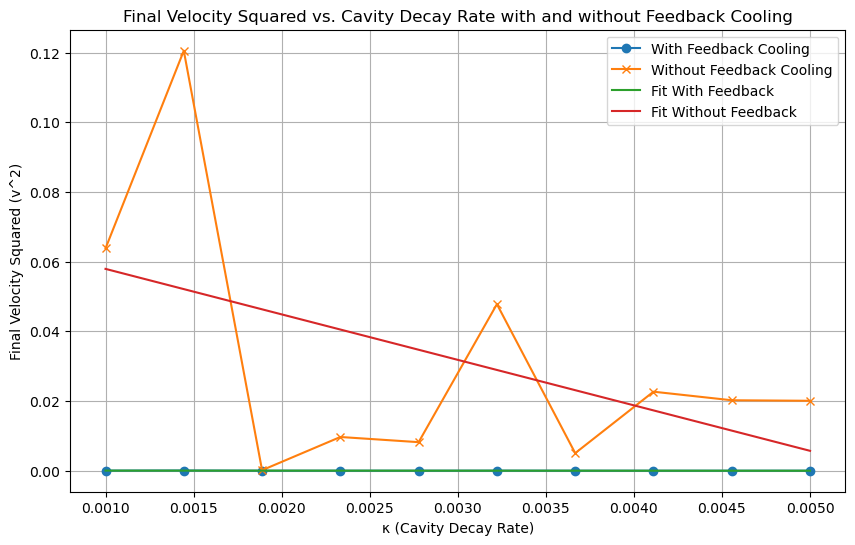

With Feedback Cooling: slope = -0.008140935299817178 intercept = 3.832870421301428e-05
Without Feedback Cooling: slope = -13.05539155405796 intercept = 0.0709837032788612


In [14]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import linregress
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
gamma = 1.0  # Atomic decay rate
delta_a = 35.0  # Atomic detuning
g = 16.0  # Coupling constant
eta = 1.0  # Stochastic force term
hbar = 1.0545718e-34  # Reduced Planck constant

# Feedback parameters
feedback_gain = 1  # Gain factor for the feedback mechanism
integration_time = 0.1  # Integration time for feedback in seconds

# Langevin equation for atomic motion with feedback
def langevin(t, y, beta, eta, feedback_gain, rng):
    v, p = y
    # Feedback force calculation
    feedback_force = -feedback_gain * v
    # Langevin equations with feedback force
    dvdt = -beta * v + feedback_force + eta * rng.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Langevin equation for atomic motion without feedback
def langevin_no_feedback(t, y, beta, eta, rng):
    v, p = y
    # Langevin equations without feedback force
    dvdt = -beta * v + eta * rng.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Function to simulate the system
def simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=True):
    if feedback:
        sol = solve_ivp(langevin, t_span, y0, args=(beta, eta, feedback_gain, rng), t_eval=np.linspace(t_span[0], t_span[1], 100))
    else:
        sol = solve_ivp(langevin_no_feedback, t_span, y0, args=(beta, eta, rng), t_eval=np.linspace(t_span[0], t_span[1], 100))
    return sol.t, sol.y[0], sol.y[1]

# Prepare random number generator
rng = np.random.default_rng()

# Perform simulations for different κ values
kappas = np.linspace(0.001, 0.005, 10)
t_span = (0, 10)
y0 = [0.1, 0.01]  # Initial conditions: [initial velocity, initial momentum]

velocities_with_feedback = []
velocities_without_feedback = []

for kappa in tqdm(kappas, desc="Simulating with feedback", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    t, v, p = simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=True)
    velocities_with_feedback.append(v[-1]**2)  # Record the final velocity squared

for kappa in tqdm(kappas, desc="Simulating without feedback", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    t, v, p = simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=False)
    velocities_without_feedback.append(v[-1]**2)  # Record the final velocity squared

# Linear fit for velocities with feedback
slope_with_feedback, intercept_with_feedback, r_value_with_feedback, p_value_with_feedback, std_err_with_feedback = linregress(kappas, velocities_with_feedback)

# Linear fit for velocities without feedback
slope_without_feedback, intercept_without_feedback, r_value_without_feedback, p_value_without_feedback, std_err_without_feedback = linregress(kappas, velocities_without_feedback)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(kappas, velocities_with_feedback, marker='o', label='With Feedback Cooling')
plt.plot(kappas, velocities_without_feedback, marker='x', label='Without Feedback Cooling')

# Plot linear fit lines
plt.plot(kappas, slope_with_feedback * kappas + intercept_with_feedback, label='Fit With Feedback')
plt.plot(kappas, slope_without_feedback * kappas + intercept_without_feedback, label='Fit Without Feedback')

plt.xlabel('κ (Cavity Decay Rate)')
plt.ylabel('Final Velocity Squared (v^2)')
plt.title('Final Velocity Squared vs. Cavity Decay Rate with and without Feedback Cooling')
plt.legend()
plt.grid(True)
plt.show()

# Print linear fit parameters
print("With Feedback Cooling: slope =", slope_with_feedback, "intercept =", intercept_with_feedback)
print("Without Feedback Cooling: slope =", slope_without_feedback, "intercept =", intercept_without_feedback)


## 增加同一$\kappa$下的重复次数取平均

Simulating without feedback: 100%|██████████| 20/20 [01:55<00:00,  5.78s/kappa]


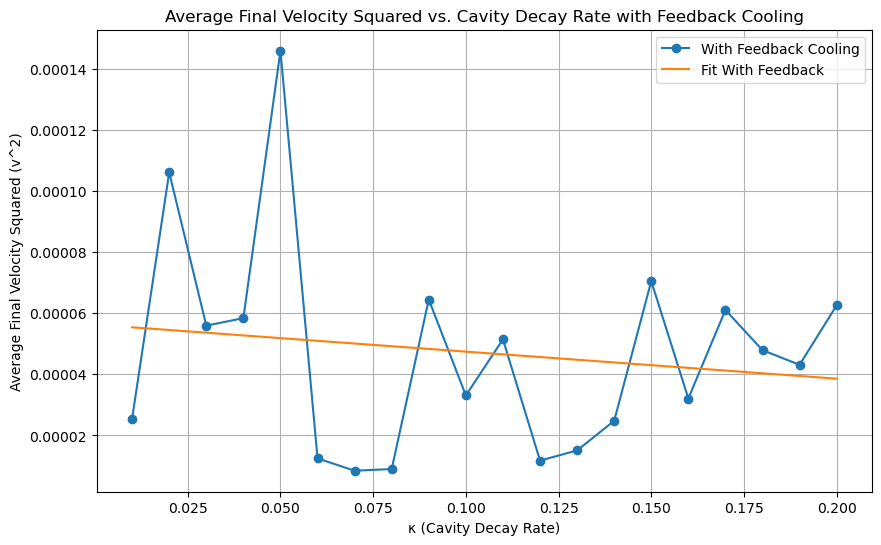

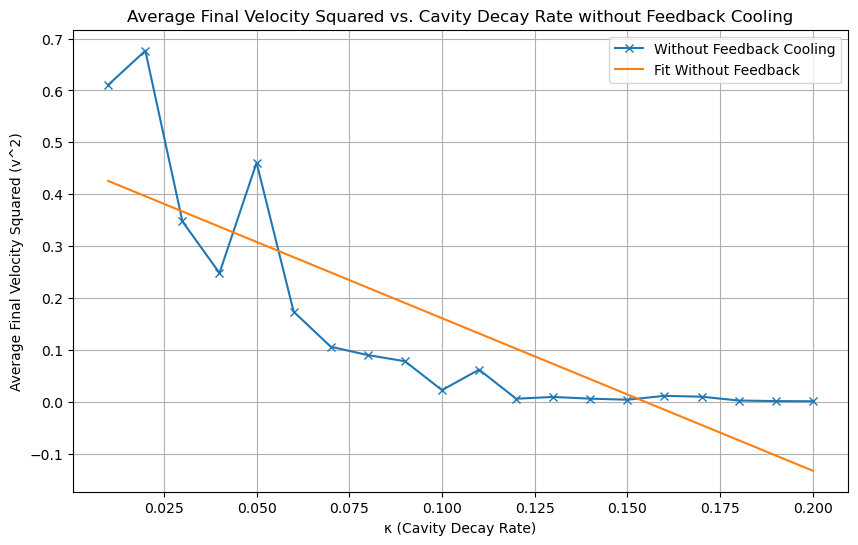

With Feedback Cooling: slope = -8.843204448945228e-05 intercept = 5.62644797884794e-05
Without Feedback Cooling: slope = -2.9401475667442662 intercept = 0.4550483867659477


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import linregress
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
gamma = 1.0  # Atomic decay rate
delta_a = 35.0  # Atomic detuning
g = 16.0  # Coupling constant
eta = 1.0  # Stochastic force term
hbar = 1.0545718e-34  # Reduced Planck constant
# Feedback parameters
feedback_gain = 1  # Gain factor for the feedback mechanism
integration_time = 0.2  # Integration time for feedback in seconds

# Langevin equation for atomic motion with feedback
def langevin(t, y, beta, eta, feedback_gain, rng):
    v, p = y
    # Feedback force calculation
    feedback_force = -feedback_gain * v
    # Langevin equations with feedback force
    dvdt = -beta * v + feedback_force + eta * rng.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Langevin equation for atomic motion without feedback
def langevin_no_feedback(t, y, beta, eta, rng):
    v, p = y
    # Langevin equations without feedback force
    dvdt = -beta * v + eta * rng.normal()
    dpdt = -p  # Simplified for illustration
    return [dvdt, dpdt]

# Function to simulate the system
def simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=True):
    if feedback:
        sol = solve_ivp(langevin, t_span, y0, args=(beta, eta, feedback_gain, rng), t_eval=np.linspace(t_span[0], t_span[1], 50))
    else:
        sol = solve_ivp(langevin_no_feedback, t_span, y0, args=(beta, eta, rng), t_eval=np.linspace(t_span[0], t_span[1], 50))
    return sol.t, sol.y[0], sol.y[1]

# Prepare random number generator
rng = np.random.default_rng()

# Perform simulations for different κ values
kappas = np.linspace(0.01, 0.2, 20)
t_span = (0, 20)
y0 = [1, 0.1]  # Initial conditions: [initial velocity, initial momentum]

simulations_per_kappa = 5  # Number of simulations per kappa value

velocities_with_feedback = []
velocities_without_feedback = []

# Simulate with feedback
for kappa in tqdm(kappas, desc="Simulating with feedback", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    velocities = []
    for _ in range(simulations_per_kappa):
        t, v, p = simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=True)
        velocities.append(v[-1]**2)  # Record the final velocity squared
    avg_velocity_with_feedback = np.mean(velocities)
    velocities_with_feedback.append(avg_velocity_with_feedback)

# Simulate without feedback
for kappa in tqdm(kappas, desc="Simulating without feedback", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    velocities = []
    for _ in range(simulations_per_kappa):
        t, v, p = simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=False)
        velocities.append(v[-1]**2)  # Record the final velocity squared
    avg_velocity_without_feedback = np.mean(velocities)
    velocities_without_feedback.append(avg_velocity_without_feedback)

# Linear fit for velocities with feedback
slope_with_feedback, intercept_with_feedback, r_value_with_feedback, p_value_with_feedback, std_err_with_feedback = linregress(kappas, velocities_with_feedback)

# Linear fit for velocities without feedback
slope_without_feedback, intercept_without_feedback, r_value_without_feedback, p_value_without_feedback, std_err_without_feedback = linregress(kappas, velocities_without_feedback)

# Plot the results for with feedback
plt.figure(figsize=(10, 6))
plt.plot(kappas, velocities_with_feedback, marker='o', label='With Feedback Cooling')
plt.plot(kappas, slope_with_feedback * kappas + intercept_with_feedback, label='Fit With Feedback')
plt.xlabel('κ (Cavity Decay Rate)')
plt.ylabel('Average Final Velocity Squared (v^2)')
plt.title('Average Final Velocity Squared vs. Cavity Decay Rate with Feedback Cooling')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for without feedback
plt.figure(figsize=(10, 6))
plt.plot(kappas, velocities_without_feedback, marker='x', label='Without Feedback Cooling')
plt.plot(kappas, slope_without_feedback * kappas + intercept_without_feedback, label='Fit Without Feedback')
plt.xlabel('κ (Cavity Decay Rate)')
plt.ylabel('Average Final Velocity Squared (v^2)')
plt.title('Average Final Velocity Squared vs. Cavity Decay Rate without Feedback Cooling')
plt.legend()
plt.grid(True)
plt.show()

# Print linear fit parameters
print("With Feedback Cooling: slope =", slope_with_feedback, "intercept =", intercept_with_feedback)
print("Without Feedback Cooling: slope =", slope_without_feedback, "intercept =", intercept_without_feedback)


# 程序运行中，勿动 ↑

# 理论模型如下

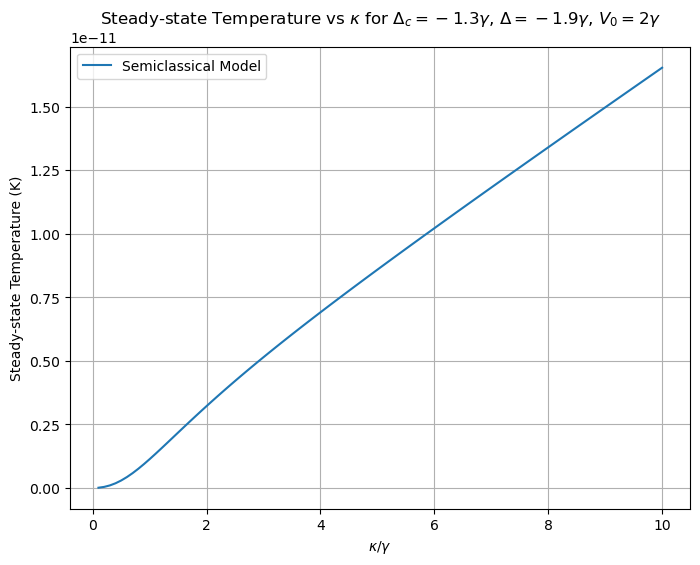

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
hbar = 1.0545718e-34  # Planck's constant over 2*pi (Joule*second)
k_B = 1.380649e-23    # Boltzmann constant (Joule/Kelvin)
gamma = 1.0           # Decay rate (set to 1 for normalization)
delta_c = -1.3 * gamma  # Cavity detuning
delta = -1.9 * gamma   # Atom-cavity detuning
V0 = 2.0 * gamma       # Coupling constant

# Function to calculate steady-state temperature
def steady_state_temperature(kappa):
    # Diffusion coefficient D
    D = hbar**2 * kappa**2 * (2/5) * (V0**2) / (kappa**2 + delta_c**2)
    # Friction coefficient b (approximate)
    b = 2 * hbar * V0**2 / (kappa + gamma)
    # Steady-state temperature T = D / (b * k_B)
    T = D / (b * k_B)
    return T

# Range of kappa values
kappa_values = np.linspace(0.1 * gamma, 10 * gamma, 100)
temperatures = np.array([steady_state_temperature(kappa) for kappa in kappa_values])

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(kappa_values / gamma, temperatures, label='Semiclassical Model')
plt.xlabel(r'$\kappa / \gamma$')
plt.ylabel(r'Steady-state Temperature (K)')
plt.title(r'Steady-state Temperature vs $\kappa$ for $\Delta_c = -1.3\gamma$, $\Delta = -1.9\gamma$, $V_0 = 2\gamma$')
plt.legend()
plt.grid(True)
plt.show()


# 计算加入反馈后的温度

Simulating with feedback: 100%|██████████| 10/10 [2:35:32<00:00, 933.30s/kappa] 


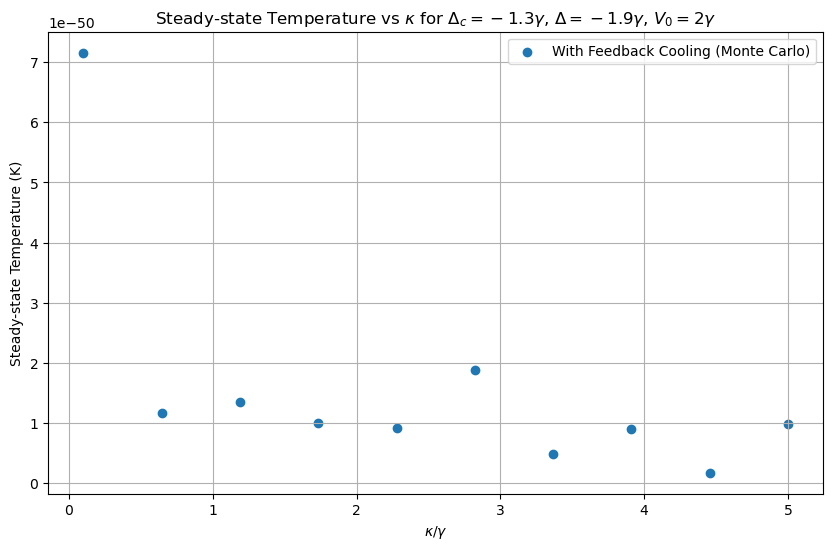

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import linregress
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
gamma = 1.0  # Atomic decay rate
delta_c = -1.3 * gamma  # Cavity detuning
delta = -1.9 * gamma  # Atomic detuning
V0 = 2.0 * gamma  # Coupling constant
hbar = 1.0545718e-34  # Reduced Planck constant
k_B = 1.380649e-23  # Boltzmann constant

# Feedback parameters
feedback_gain = 1  # Gain factor for the feedback mechanism
integration_time = 0.3  # Integration time for feedback in seconds

# Langevin equation for atomic motion with feedback
def langevin(t, y, beta, eta, feedback_gain, rng):
    v, p = y
    feedback_force = -feedback_gain * v
    dvdt = -beta * v + feedback_force + eta * rng.normal()
    dpdt = -p
    return [dvdt, dpdt]

# Langevin equation for atomic motion without feedback
def langevin_no_feedback(t, y, beta, eta, rng):
    v, p = y
    dvdt = -beta * v + eta * rng.normal()
    dpdt = -p
    return [dvdt, dpdt]

# Function to simulate the system
def simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=True):
    if feedback:
        sol = solve_ivp(langevin, t_span, y0, args=(beta, eta, feedback_gain, rng), t_eval=np.linspace(t_span[0], t_span[1], 50))
    else:
        sol = solve_ivp(langevin_no_feedback, t_span, y0, args=(beta, eta, rng), t_eval=np.linspace(t_span[0], t_span[1], 50))
    return sol.t, sol.y[0], sol.y[1]

# Prepare random number generator
rng = np.random.default_rng()

# Perform simulations for different κ values
kappas = np.linspace(0.1 * gamma, 5 * gamma, 10)  # Adjusted to match the range in the article
t_span = (0, 20)
y0 = [1, 0.1]  # Initial conditions: [initial velocity, initial momentum]

simulations_per_kappa = 5  # Number of simulations per kappa value

temperatures_with_feedback = []

# Simulate with feedback
for kappa in tqdm(kappas, desc="Simulating with feedback", unit="kappa"):
    beta = kappa  # Assuming beta proportional to kappa for this example
    velocities = []
    for _ in range(simulations_per_kappa):
        t, v, p = simulate_cooling(beta, V0, t_span, y0, feedback_gain, rng, feedback=True)
        velocities.append(v[-1]**2)  # Record the final velocity squared
    avg_temperature_with_feedback = np.mean(velocities) * hbar**2 / (2 * k_B)
    temperatures_with_feedback.append(avg_temperature_with_feedback)

# Plot the results for with feedback
plt.figure(figsize=(10, 6))
plt.scatter(kappas / gamma, temperatures_with_feedback, marker='o', label='With Feedback Cooling (Monte Carlo)')
plt.xlabel(r'$\kappa / \gamma$')
plt.ylabel(r'Steady-state Temperature (K)')
plt.title(r'Steady-state Temperature vs $\kappa$ for $\Delta_c = -1.3\gamma$, $\Delta = -1.9\gamma$, $V_0 = 2\gamma$')
plt.legend()
plt.grid(True)
plt.show()


# 不加反馈的温度

Simulating without feedback: 100%|██████████| 20/20 [1:02:18<00:00, 186.95s/kappa]


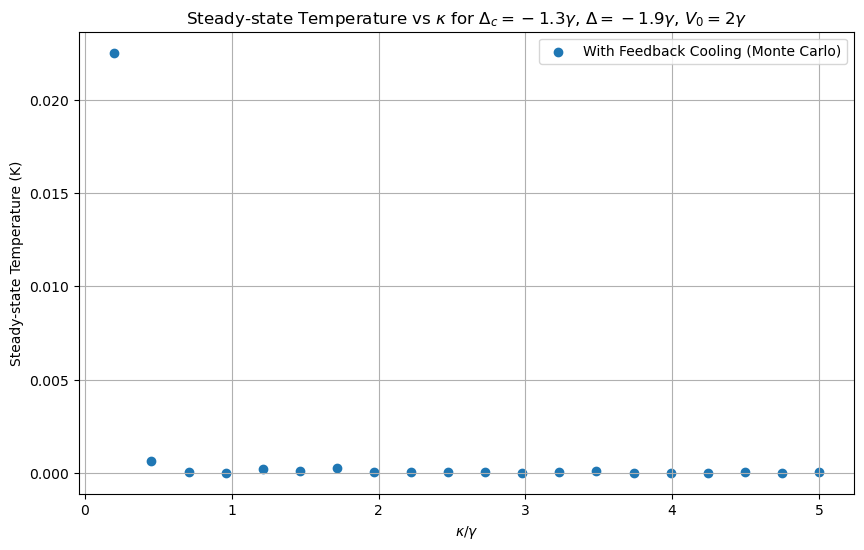

In [31]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import linregress
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
gamma = 1.0  # Atomic decay rate
delta_c = -1.3 * gamma  # Cavity detuning
delta = -1.9 * gamma  # Atomic detuning
V0 = 2.0 * gamma  # Coupling constant
hbar = 1.0545718e-34  # Reduced Planck constant
k_B = 1.380649e-23  # Boltzmann constant

# Langevin equation for atomic motion without feedback
def langevin_no_feedback(t, y, beta, eta, rng):
    v, p = y
    dvdt = -beta * v +  eta * rng.normal()
    dpdt = -p
    return [dvdt, dpdt]

# Function to simulate the system
def simulate_cooling(beta, eta, t_span, y0, feedback_gain, rng, feedback=True):
    if feedback:
        sol = solve_ivp(langevin, t_span, y0, args=(beta, eta, feedback_gain, rng), t_eval=np.linspace(t_span[0], t_span[1], 20))
    else:
        sol = solve_ivp(langevin_no_feedback, t_span, y0, args=(beta, eta, rng), t_eval=np.linspace(t_span[0], t_span[1], 20))
    return sol.t, sol.y[0], sol.y[1]

# Prepare random number generator
rng = np.random.default_rng()

# Perform simulations for different κ values
kappas = np.linspace(0.2 * gamma, 5 * gamma, 20)  # Adjusted to match the range in the article
t_span = (0, 20)
y0 = [1, 0.1]  # Initial conditions: [initial velocity, initial momentum]

simulations_per_kappa = 2  # Number of simulations per kappa value

temperatures_with_feedback = []

# Simulate with feedback
for kappa in tqdm(kappas, desc="Simulating without feedback", unit="kappa"):
    beta = kappa   # Assuming beta proportional to kappa for this example
    velocities = []
    for _ in range(simulations_per_kappa):
        t, v, p = simulate_cooling(beta, V0, t_span, y0, feedback_gain, rng, feedback=False)
        velocities.append(v[-1]**2)  # Record the final velocity squared
    avg_temperature_with_feedback = np.mean(velocities)
    temperatures_with_feedback.append(avg_temperature_with_feedback)

# Plot the results for with feedback
plt.figure(figsize=(10, 6))
plt.scatter(kappas / gamma, temperatures_with_feedback, marker='o', label='With Feedback Cooling (Monte Carlo)')
plt.xlabel(r'$\kappa / \gamma$')
plt.ylabel(r'Steady-state Temperature (K)')
plt.title(r'Steady-state Temperature vs $\kappa$ for $\Delta_c = -1.3\gamma$, $\Delta = -1.9\gamma$, $V_0 = 2\gamma$')
plt.legend()
plt.grid(True)
plt.show()